# Пример нейросетки для генерации рекомендаций

## Тестовые данные IVI.ru

In [616]:
import pandas as pd
import numpy as np

# загружаем данные
raw_watch = pd.read_csv('./test_task/content_watch.csv', sep = ',', usecols=[0,1]) # только пары user_id - item_id
print raw_watch.head(3)
print 'train samle len: {}\n{}'.format(raw_watch.shape[0], '-'*20)

# аггрегируем сессии смотрения пользователей
USER_SESSIONS = (raw_watch.groupby('user_index')['item_id'].apply(np.array).apply(np.unique))
# важный момент - удаляем сессии, где меньше двух просмотров контента, т.к. на них нельзя обучится
LEARN_SAMPLE = USER_SESSIONS[USER_SESSIONS.apply(len) > 1]
print LEARN_SAMPLE.head(2)
print 'uniq users: {}'.format(LEARN_SAMPLE.shape[0])

   user_index     item_id
0  1677306600  2011099417
1  1677306600 -1495220568
2  1677306600  1642882038
train samle len: 743885
--------------------
user_index
-2147407952    [-549996512, -14855385, 6761694, 510527058, 17...
-2147298847    [-672834242, -177246609, -14855385, 6761694, 1...
Name: item_id, dtype: object
uniq users: 72529


In [617]:
# загружаем данные для теста
TEST_SESSIONS = pd.read_csv('./test_task/test_set.csv', sep=',')\
                  .groupby('user_index')['item_id']\
                  .apply(np.array).apply(np.unique)
TEST_SESSIONS.head(1)

user_index
-2146936447    [-953257789]
Name: item_id, dtype: object

## Baseline - метод ассоциаций

почитать тут: http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.428.6731&rep=rep1&type=pdf

In [618]:
# собираем полные списки пользователей и фильмов (трейн + тест)
content = (raw_watch[['item_id']]\
    .append(pd.read_csv('./test_task/test_set.csv', sep=',', usecols = ['item_id']), ignore_index = True)\
    .item_id).drop_duplicates().reset_index(drop=True)
users = (raw_watch[['user_index']]\
    .append(pd.read_csv('./test_task/test_set.csv', sep=',', usecols = ['user_index']), ignore_index = True)\
    .user_index).drop_duplicates().reset_index(drop=True)
# строим индексы по полученному набору
content_index = {y : x for x,y in content.to_dict().iteritems() }
user_index = {y : x for x,y in users.to_dict().iteritems() }
print content.shape, users.shape

(7245,) (108124,)


In [619]:
%%time
# сессии смотрения
LEARN_SAMPLE = LEARN_SAMPLE.reset_index()
# длина сессии смотрения (потом пригодится для контроля)
LEARN_SAMPLE['ses_len'] = LEARN_SAMPLE.apply(lambda x: x[1].shape[0] ,axis=1)
# по столбцам - идентификаторы пользователей
LEARN_SAMPLE['user_ind'] = LEARN_SAMPLE.apply(lambda x: tuple(np.ones(x[2])*x[0]), axis=1)
# индексы строк
user_ind = np.concatenate(LEARN_SAMPLE.user_ind.values, axis=0) # идентификаторы пользователей
sparse_users = [user_index[i] for i in user_ind]
# индексы столбцов
content_ind = np.concatenate(LEARN_SAMPLE.item_id.values, axis=0)
sparse_content = [content_index[i] for i in content_ind]
# сохраняем константы для матрицы просмотров
CONTENT_NUM = len(content_index)
USER_NUM =  len(user_index)
SESSIONS_NUM = LEARN_SAMPLE['ses_len'].sum()
print 'CONTENT_NUM = {},USER_NUM = {},SESSIONS_NUM = {}'.format(CONTENT_NUM, USER_NUM, SESSIONS_NUM)

CONTENT_NUM = 7245,USER_NUM = 108124,SESSIONS_NUM = 699566
CPU times: user 4.06 s, sys: 0 ns, total: 4.06 s
Wall time: 4.05 s


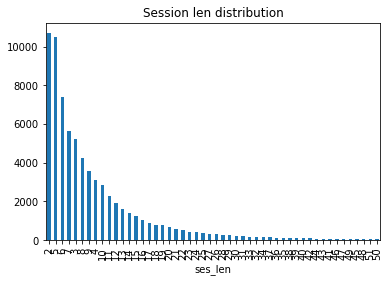

In [1038]:
%matplotlib inline
# построим распределение пользователей по длине сессии
LEARN_SAMPLE.groupby(['ses_len'])['user_index']\
        .agg('count')\
        .sort_values(ascending=False).head(50)\
        .plot(kind = 'bar', title = 'Session len distribution')

In [620]:
# формируем матрицу просмотров
from scipy import sparse
from sklearn.preprocessing import binarize
V = sparse.csr_matrix((np.ones( SESSIONS_NUM ),\
                      (sparse_content, sparse_users)),\
                      shape=(CONTENT_NUM , USER_NUM))
V

<7245x108124 sparse matrix of type '<type 'numpy.float64'>'
	with 699566 stored elements in Compressed Sparse Row format>

In [621]:
%%time
xUy = V.dot(V.T) # сколько пользователей смотрели одновременно x(строка) и y(столбец)
# суммируем элементы каждой строки - сколько пользователей смотрело x вместе с другими фильмами всего
x = sparse.csr_matrix(V.sum(axis=1))
# умножаем построчно если x не смотрели с y, то в magic будет 0, иначе будет общее число , которые смотрели x
total_x = binarize(xUy).multiply(x.T)
# из общего числа пользователей, которые смотрели x вычитаем тех, которые смотрели x и у
_xUy = total_x - xUy
# достаём индексы ненулевых элементов, на которые будем в дальнейшем делить
rows, cols = _xUy.nonzero()
xUy_array = xUy[rows, cols].A.reshape(-1)
# получаем матрицу схожести S
S = sparse.csr_matrix((xUy_array / _xUy.data, (rows, cols)), xUy.shape)

CPU times: user 5.08 s, sys: 148 ms, total: 5.23 s
Wall time: 5.23 s


#### Пример рекомендаций

Берём сессию смотрения пользователя, достаём из матрицы S для последнего просмотра в сессии достаем top-20 релевантного контента

In [1029]:
def recall(user_id, verbose = False):
    true_view = [content_index[i] for i in TEST_SESSIONS.loc[user_id]]
    history = np.unique(USER_SESSIONS.loc[user_id]) # в сессии оставляем только уникальные просмотры контента
    history = [content_index[i] for i in history] # достаём индексы контента
    not_view =  np.setdiff1d(xrange(CONTENT_NUM), history) # контент, который не смотрели
    # вишенка на торте - находим для каждого фильма максимальную релевантность, пользуясь историей пользователя
    relevant_content = ( (S[history,:].max(axis=0)).A[0])[not_view].argsort()[-20:][::-1]
    TP = np.intersect1d(relevant_content, true_view) # true positive, порекомендовали и подошло
    recall = TP.shape[0] /  float(len(true_view))
    if verbose:
        print 'recommendations ', relevant_content
        print 'true history', true_view
        print 'true positive ', TP
        print 'recall = {}'.format( recall )
    return recall

random_user = np.random.choice(TEST_SESSIONS.index.values)
recall(random_user,verbose = True)

recommendations  [2631 6367 6771 4146 1963 6686 6173 5670 5259 3128 6750 6446 2628 7062 7060
 6737 6148 6773 6776 6778]
true history [594, 4403, 368, 6666, 96, 3072, 948, 434, 251, 904, 319, 16, 25, 63, 875]
true positive  []
recall = 0.0


0.0

### Считаем качество модели

In [1019]:
total_recall = [recall(user,verbose = False) for user in TEST_SESSIONS.index]
print 'avg_recall = {:.2f}%'.format(100*sum(total_recall) / float(len(total_recall)))

avg_recall = 0.52%


## Model

In [ ]:
# определяем константы
USER_NUM = USER_SESSIONS.shape[0]

def get_item():
    # генерим тензоры из набора фильмов пользователя
    ind = np.random.randint(0,high = USER_NUM-1)
    ses = np.array(USER_SESSIONS.iloc[ind]) # сессия
    # заменяем фильмы в сессии на их индексы
    sample_session = np.array([content_index[i] for i in USER_SESSIONS.iloc[ind]])
    return Variable(torch.from_numpy(sample_session[:-1]).long()), Variable(torch.from_numpy(sample_session[1:]).long())

get_item()

In [155]:
import numpy as np
import time
#-- для RNN используем torch --
import torch
import torch.nn as nn
from torch.autograd import Variable
#----------------

In [865]:
# сетка
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, n_hidden_layers, output_size):
        '''
        n_layers - число скрытых слоёв
        hidden_size - число нейронов в скрытом слое
        input_size == output_size - размер библиотеки контента
        '''
        super(RNN, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_hidden_layers
        # архитектура сети
        self.encoder = nn.Embedding(input_size, hidden_size) 
        self.gru = nn.GRU(hidden_size, hidden_size, n_hidden_layers) 
        self.decoder = nn.Linear(hidden_size, output_size)
    
    def forward(self, input, hidden):
        input = self.encoder(input.view(1, -1))
        output, hidden = self.gru(input.view(1, 1, -1), hidden)
        output = self.decoder(output.view(1, -1))
        return output, hidden

    def init_hidden(self):
        return Variable(torch.zeros(self.n_layers, 1, self.hidden_size))
    
# рекомендательная система
class NeuroHydra():
    def __init__(self, neural_network):
        ''' На вход принимаем модельку и 
        вектор доступного контента
        '''
        self.net = neural_network
        self.loss = 0
        self.all_losses = []
    
    def zero_state(self):
        self.net.zero_grad()
        self.criterion = nn.CrossEntropyLoss()
        
    def train(self, inp, target):
        # начальное состояние
        self.zero_state()
        #print inp.size()
        chunk_len = int(inp.size()[0])
        loss = 0
        # запускаем процесс обучения
        hidden = self.net.init_hidden()
        for c in range(chunk_len): # итерируем по чанкам
            output, hidden = self.net(inp[c], hidden) # encoder->GRU(LTSM ячейка)->decoder
            loss += self.criterion(input = output, target = target[c])
        loss.backward() # вычисляем градиент
        self.optimizer.step()
        return loss.data[0] / chunk_len # усредняем потери
        
    def evaluate(user_history = [7029], num_recommed=10, temperature=0.8):
        ''' Этап эксплуатации сети
        на вход получаем вектор фильмов пользователя user_history
        генерируем по ним num_recommed рекомендаций
        temperature - чем ниже, тем разнообразней рекомендации
        '''
        prime_input = torch.from_numpy(np.array(user_history)).long()
        predicted = np.array([])
        # "прогреваем" сетку историей смотрения юзера
        hidden = self.net.init_hidden()
        for p in prime_input[:-1]:
            _, hidden = self.net(p, hidden)
        inp = prime_input[-1]
        for p in range(num_recommed):
            output, hidden = self.net(inp, hidden)
            # нахлобучиваем софтмакс на полносвязный слой
            output_dist = output.data.view(-1).div(temperature).exp() 
            recommend = torch.multinomial(output_dist, 1)[0]
            predicted = np.append(predicted, recommend)
            inp = recommend
        return predicted

    def learn_model(self, lr, n_epoch):
        start = time.time()
        loss_avg = 0
        self.optimizer = torch.optim.Adam(self.net.parameters(), lr=lr)
        self.n_epoch = n_epoch
        plot_every = 10
        for epoch in range(n_epoch):
            inp, target = get_item() # выдёргиваем случайного пользователя
            loss = self.train(inp, target)
            loss_avg += loss
            if epoch % plot_every == 0: # иногда обнуляем потери и смотри результат
                self.all_losses.append(loss_avg / plot_every)
                loss_avg = 0

## Обучаем модель

In [873]:
# параметры из nn_config можно подбирать
DATA_TYPE = 'films'
content_num = len(content_index)

nn_config = {'input_size': content_num,\
             'hidden_size' : 100,\
             'n_hidden_layers' : 2,\
             'output_size': content_num}
learn_config = { 'n_epoch' : 10000,\
                 'lr' : 0.005 }

rnn = RNN(**nn_config)
recommender = NeuroHydra(rnn)
recommender.learn_model(**learn_config)

### Обучение модели - смотри график потерь

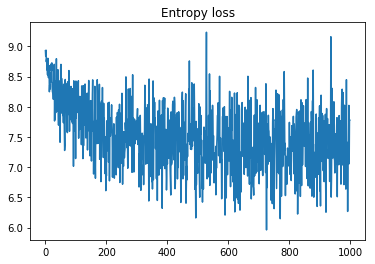

In [874]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline

plt.figure()
plt.title('Entropy loss')
plt.plot(recommender.all_losses[1:])